In [73]:
%matplotlib qt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot
import scipy

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier

In [5]:
fv = pd.read_csv("total_full_data.csv")

# Explore data

In [6]:
fv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   158 non-null    float64
 1   Longitude  158 non-null    float64
 2   k_values   158 non-null    float64
 3   th_values  158 non-null    float64
 4   u_values   158 non-null    float64
 5   gravity    158 non-null    float64
 6   magtivity  158 non-null    float64
 7   dyke       158 non-null    int64  
 8   struc      158 non-null    int64  
 9   geo        158 non-null    object 
 10  H2         158 non-null    int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 13.7+ KB


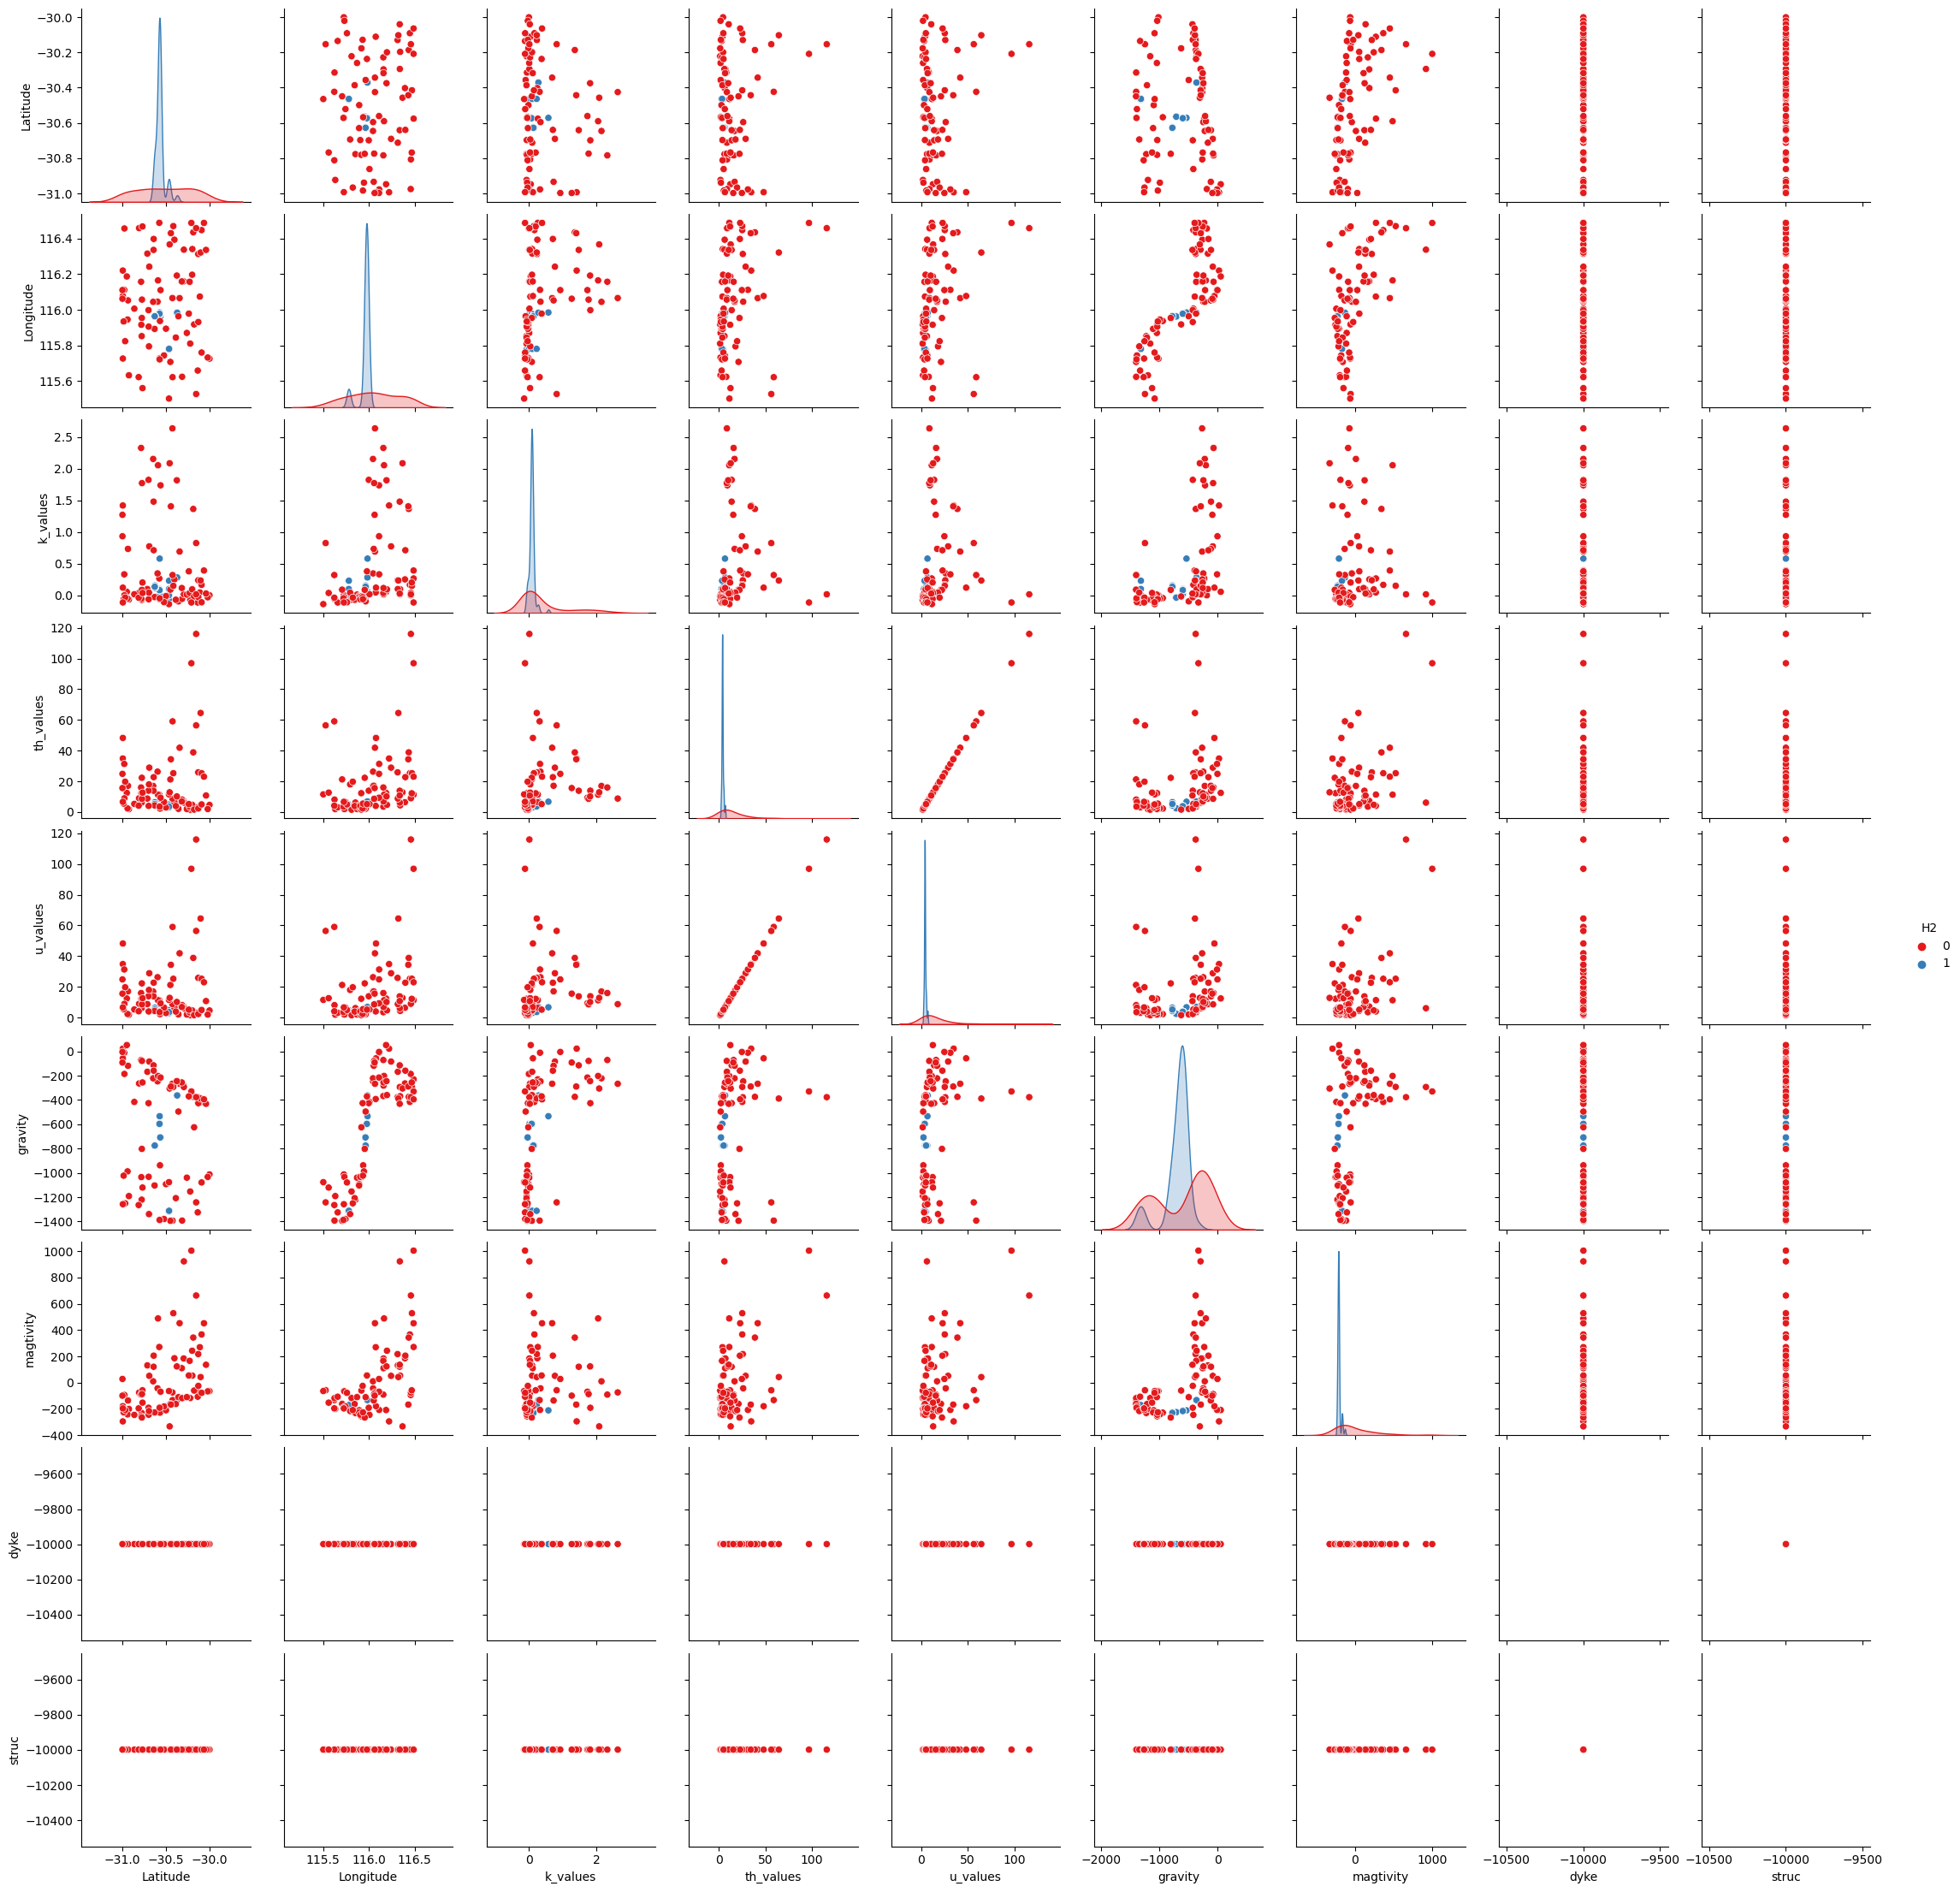

In [7]:
sns.pairplot(fv,hue='H2',palette="Set1",diag_kind="auto")

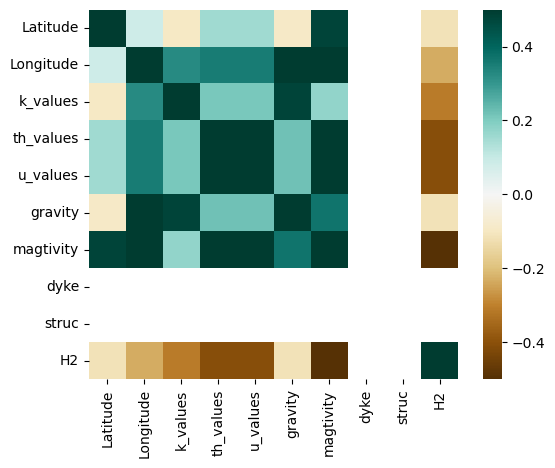

In [8]:
#Plot a heatmap for how correlated each of the features are
corr = fv.corr() 

sns.heatmap(corr,
            cmap=plt.cm.BrBG, 
            vmin=-0.5, vmax=0.5, 
            square=True,
            xticklabels=True, yticklabels=True,
            );

# Machine learning

In [10]:
#Create the 'feature vector' and a 'target classification vector'
features=fv.iloc[:,2:-1]
targets=fv.H2

features.columns

Index(['k_values', 'th_values', 'u_values', 'gravity', 'magtivity', 'dyke',
       'struc', 'geo'],
      dtype='object')

In [11]:
numfts = ['k_values', 'th_values', 'u_values', 'gravity', 'magtivity']
catfts = ['dyke', 'struc', 'geo']

In [12]:
for i in features.geo:
    if not isinstance(i, str):
        print(i)

In [13]:
#Create the ML classifier with numerical and categorical data
#Scale, and replace missing values
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(missing_values=-9999., strategy='median')),
    ('scaler', StandardScaler())])

In [14]:
numeric_transformer

Pipeline(steps=[('imputer',
                 SimpleImputer(missing_values=-9999.0, strategy='median')),
                ('scaler', StandardScaler())])

In [15]:
#Encode categorical data and fill missing values with default 0
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [17]:
#Combine numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numfts),
        ('cat', categorical_transformer, catfts)])


In [18]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(missing_values=-9999.0,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['k_values', 'th_values', 'u_values',
                                  'gravity', 'magtivity']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['dyke', 'struc', 'geo'])])

In [19]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(random_state=1))])
                #('classifier', MLPClassifier(solver='adam', alpha=0.001, max_iter=10000))])

In [20]:
rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=-9999.0,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['k_values', 'th_values',
                                                   'u_values', 'gravity',
                                                   'magtivity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dyke', 'struc', 'geo'])])),
                ('classifier', RandomForestClassifier(random_state=1))])

Tranining the Clasifier...
Done RF. Now scoring...
RF 5-fold cross validation Scores: [0.84375    1.         0.9375     1.         0.70967742]
SCORE Mean: 0.90 STD: 0.11 



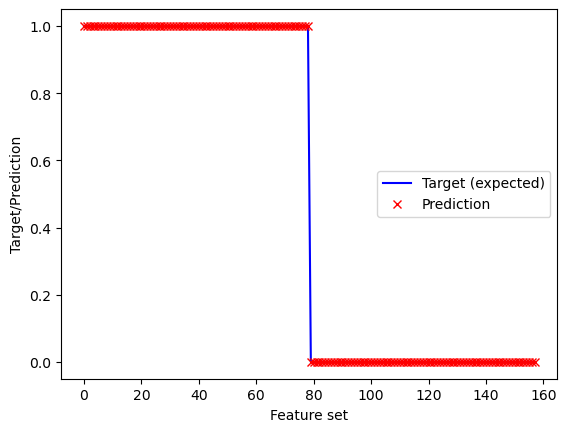

In [21]:
print('Tranining the Clasifier...')
rf.fit(features,targets)

print("Done RF. Now scoring...")
scores = cross_val_score(rf, features, targets, cv=5)

print("RF 5-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b-',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend(loc=7)

In [22]:
print("Features:",np.shape(features),"Targets:",np.shape(targets))
rf.fit(features,targets)
scores = cross_val_score(rf, features,targets, cv=5)
print("RF CV-Scores: ",scores)
print("CV-SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores))
#print("OOB score:",rf.steps[-1][1].oob_score_)

print("Targets (expected result):")
print(targets.values)
print("Prediction (actual result):")
print(rf.predict(features))

Features: (158, 8) Targets: (158,)
RF CV-Scores:  [0.84375    1.         0.9375     1.         0.70967742]
CV-SCORE Mean: 0.90 STD: 0.11
Targets (expected result):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Prediction (actual result):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


In [23]:
# Gather the importance measures
ft_imp=[]
ft_lab=[]

for i,lab in enumerate(np.append(numfts,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(catfts))):
    ft_imp.append(rf.steps[-1][1].feature_importances_[i])
    ft_lab.append(lab)

In [35]:
rf.steps[-1][1].feature_importances_

array([0.10589729, 0.16452569, 0.15035993, 0.16080768, 0.24375412,
       0.        , 0.        , 0.13503736, 0.00173631, 0.00635331,
       0.00726135, 0.00579761, 0.00254321, 0.01368286, 0.00224328])

In [75]:
#Make the bar plot
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))
datalength=len(ft_imp)

#Create a new figure
fig,ax = plt.subplots(figsize=(4,10))

#Plot the bar graph
rects=ax.barh(np.arange(0, datalength, step=1),ft_imps)
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)
ax.set_xlabel('Feature Importance')
print("From the Random Forest ML algorithm\nthese are the the most significant features for predicting the target bins.\n")

plt.show()

From the Random Forest ML algorithm
these are the the most significant features for predicting the target bins.



In [42]:
ft_imps, ft_labs

([0.0,
  0.0,
  0.001736311911422287,
  0.0022432817707647105,
  0.0025432071271821936,
  0.005797605795529309,
  0.006353306056707938,
  0.007261354868976659,
  0.013682856735347726,
  0.10589729456865246,
  0.13503736080130954,
  0.150359928452785,
  0.16080767684231617,
  0.16452569160744562,
  0.2437541234615605],
 ['dyke_-9999',
  'struc_-9999',
  'geo_Middle and Upper Jurassic sedimentary rocks, Perth Basin',
  'geo_Yilgarn Craton metamorphic unit',
  'geo_Warnbro Group',
  'geo_South West Terrane greenstones',
  'geo_Moora Group',
  'geo_Parmelia Group',
  'geo_Yilgarn Craton granites',
  'k_values',
  'geo_Coolyena Group',
  'u_values',
  'gravity',
  'th_values',
  'magtivity'])

# Find where to dig

In [43]:
tdf = pd.read_csv("full_mapping_data.csv")

In [44]:
tdf

,Longitude,Latitude,k_values,th_values,u_values,gravity,magtivity,dyke,struc,geo
0,115.5,-31.000000,-0.062677,1.190342,1.190342,-908.58490,-166.678760,-9999,-9999,Coolyena Group
1,115.5,-30.888889,0.063609,0.569333,0.569333,-950.02610,-178.538530,-9999,-9999,Warnbro Group
2,115.5,-30.777778,0.079801,2.507930,2.507930,-954.88430,-113.763200,-9999,-9999,"Middle and Upper Jurassic sedimentary rocks, P..."
3,115.5,-30.666667,-0.097326,29.502724,29.502724,-982.71870,-49.049440,-9999,-9999,"Middle and Upper Jurassic sedimentary rocks, P..."
4,115.5,-30.555556,-0.066425,4.709319,4.709319,-1019.28130,-53.154450,-9999,-9999,"Middle and Upper Jurassic sedimentary rocks, P..."
...,...,...,...,...,...,...,...,...,...,...
95,116.5,-30.444444,0.625715,31.916546,31.916546,-308.61783,76.927895,-9999,-9999,Yilgarn Craton granites
96,116.5,-30.333333,0.077759,8.620563,8.620563,-282.43463,706.892940,-9999,-9999,Yilgarn Craton granites
97,116.5,-30.222222,1.106263,66.925270,66.925270,-299.25748,1826.581000,-9999,-9999,Yilgarn Craton granites
98,116.5,-30.111111,1.235998,51.183697,51.183697,-383.02924,84.129430,-9999,-9999,Yilgarn Craton granites


In [45]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF_map=np.array(rf.predict_proba(tdf.iloc[:,2:]))
print("Done RF")

RF...
Done RF


In [72]:
pRF_map

array([[0.9 , 0.1 ],
       [0.82, 0.18],
       [0.83, 0.17],
       [0.98, 0.02],
       [0.84, 0.16],
       [0.99, 0.01],
       [0.98, 0.02],
       [0.99, 0.01],
       [0.98, 0.02],
       [0.97, 0.03],
       [0.99, 0.01],
       [0.81, 0.19],
       [0.59, 0.41],
       [0.95, 0.05],
       [0.97, 0.03],
       [0.93, 0.07],
       [0.98, 0.02],
       [0.96, 0.04],
       [0.92, 0.08],
       [0.97, 0.03],
       [0.91, 0.09],
       [0.85, 0.15],
       [0.4 , 0.6 ],
       [0.73, 0.27],
       [0.54, 0.46],
       [0.77, 0.23],
       [0.96, 0.04],
       [0.93, 0.07],
       [0.96, 0.04],
       [0.97, 0.03],
       [0.81, 0.19],
       [0.74, 0.26],
       [0.8 , 0.2 ],
       [0.95, 0.05],
       [0.91, 0.09],
       [0.77, 0.23],
       [0.65, 0.35],
       [0.85, 0.15],
       [1.  , 0.  ],
       [0.96, 0.04],
       [0.87, 0.13],
       [0.96, 0.04],
       [0.94, 0.06],
       [0.9 , 0.1 ],
       [0.74, 0.26],
       [0.91, 0.09],
       [0.58, 0.42],
       [1.  ,

In [51]:
# Better - Make a grid of target locations over an entire area
#100x100 takes about 1 hour! 10x10 takes about 1 minute
grid_x, grid_y = np.mgrid[115.5:116.5:10j,-31:-30:10j]

In [52]:
grid_x

array([[115.5       , 115.5       , 115.5       , 115.5       ,
        115.5       , 115.5       , 115.5       , 115.5       ,
        115.5       , 115.5       ],
       [115.61111111, 115.61111111, 115.61111111, 115.61111111,
        115.61111111, 115.61111111, 115.61111111, 115.61111111,
        115.61111111, 115.61111111],
       [115.72222222, 115.72222222, 115.72222222, 115.72222222,
        115.72222222, 115.72222222, 115.72222222, 115.72222222,
        115.72222222, 115.72222222],
       [115.83333333, 115.83333333, 115.83333333, 115.83333333,
        115.83333333, 115.83333333, 115.83333333, 115.83333333,
        115.83333333, 115.83333333],
       [115.94444444, 115.94444444, 115.94444444, 115.94444444,
        115.94444444, 115.94444444, 115.94444444, 115.94444444,
        115.94444444, 115.94444444],
       [116.05555556, 116.05555556, 116.05555556, 116.05555556,
        116.05555556, 116.05555556, 116.05555556, 116.05555556,
        116.05555556, 116.05555556],
       [11

In [55]:
new = grid_x.reshape(grid_x.size)

In [58]:
grid_x.shape

(10, 10)

In [56]:
new

array([115.5       , 115.5       , 115.5       , 115.5       ,
       115.5       , 115.5       , 115.5       , 115.5       ,
       115.5       , 115.5       , 115.61111111, 115.61111111,
       115.61111111, 115.61111111, 115.61111111, 115.61111111,
       115.61111111, 115.61111111, 115.61111111, 115.61111111,
       115.72222222, 115.72222222, 115.72222222, 115.72222222,
       115.72222222, 115.72222222, 115.72222222, 115.72222222,
       115.72222222, 115.72222222, 115.83333333, 115.83333333,
       115.83333333, 115.83333333, 115.83333333, 115.83333333,
       115.83333333, 115.83333333, 115.83333333, 115.83333333,
       115.94444444, 115.94444444, 115.94444444, 115.94444444,
       115.94444444, 115.94444444, 115.94444444, 115.94444444,
       115.94444444, 115.94444444, 116.05555556, 116.05555556,
       116.05555556, 116.05555556, 116.05555556, 116.05555556,
       116.05555556, 116.05555556, 116.05555556, 116.05555556,
       116.16666667, 116.16666667, 116.16666667, 116.16

In [60]:
#X, Y = np.meshgrid(xi, yi)
gridZ = scipy.interpolate.griddata((tdf.Longitude, tdf.Latitude), pRF_map[:,1], (grid_x, grid_y),method='linear')

In [71]:
gridZ

array([[1.00000000e-01, 1.80000000e-01, 1.70000000e-01, 2.00000000e-02,
        1.60000000e-01, 1.00000000e-02, 2.00000000e-02, 1.00000000e-02,
        2.00000000e-02, 3.00000000e-02],
       [1.00000000e-02, 1.90000000e-01, 4.10000000e-01, 5.00000000e-02,
        3.00000000e-02, 7.00000000e-02, 2.00000000e-02, 4.00000000e-02,
        8.00000000e-02, 3.00000000e-02],
       [9.00000000e-02, 1.50000000e-01, 6.00000000e-01, 2.70000000e-01,
        4.60000000e-01, 2.30000000e-01, 4.00000000e-02, 7.00000000e-02,
        4.00000000e-02, 3.00000000e-02],
       [1.90000000e-01, 2.60000000e-01, 2.00000000e-01, 5.00000000e-02,
        9.00000000e-02, 2.30000000e-01, 3.50000000e-01, 1.50000000e-01,
        7.67386155e-15, 4.00000000e-02],
       [1.30000000e-01, 4.00000000e-02, 6.00000000e-02, 1.00000000e-01,
        2.60000000e-01, 9.00000000e-02, 4.20000000e-01, 0.00000000e+00,
        6.00000000e-02, 8.00000000e-02],
       [0.00000000e+00, 1.00000000e-02, 8.00000000e-02, 2.00000000e-02,
   

In [76]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
im=plt.pcolormesh(grid_x,grid_y,gridZ,cmap='bwr',shading='auto')
ax.plot(fv[fv.H2==1].Longitude, fv[fv.H2==1].Latitude, 
        marker='x', linestyle='',markersize=5, color='y',label="H2 locations")
ax.plot(fv[fv.H2==0].Longitude, fv[fv.H2==0].Latitude, 
        marker='o', linestyle='',markersize=1, color='k',label="Random Samples")

plt.xlim(115.5,116.5)
plt.ylim(-31,-30)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.4, 0.01, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal")
cbar.set_label('Probability of H2 locations', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

